In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\CT")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\3DTomoGAN")
from plots import *
import os
import utils
import h5py
from scipy.optimize import curve_fit
from PIL import Image

import scipy.ndimage as nd

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patheffects as PathEffects

%matplotlib inline

%reload_ext autoreload
%autoreload 2

c:\Users\Bruker\anaconda3\envs\4D_CT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = r"C:\Users\Bruker\Documents\BZ"
choose_formatter(False)

In [3]:
x1, x2 = 572, 828  # 672, 928
y1, y2 = 300, 556  # 384, 640
z1, z2 = 600, 856  # 384, 640

slice = [[x1, x2], [y1, y2], [z1, z2]]

names = [
    "limestoneV3_17_55_12favg",
]

crossections = {
    # "favg6":  {"name": names[0] },
    # "favg12": { "name": names[1]},
    # "favg24": {"name": names[2]},
}

identifiers = [
    "gt",
    "Rec_0_1_fdk_enhanced_700428728",
    "Rec_0_2_fdk_enhanced_700428728",
    "Rec_0_3_fdk_enhanced_700428728",
    "Rec_0_5_fdk_enhanced_700428728",
    "Rec_0_8_fdk_enhanced_700428728",

]
keys = [
    "gt",
    "17_enhanced",
    "34_enhanced",
    "51_enhanced",
    "85_enhanced",
    "136_enhanced",
]

# for k, v in crossections.items():
for j,(id,key) in enumerate(zip(identifiers, keys)):

    if key.endswith("enhanced"):
        x1, x2 = 0,256
        y1, y2 = 0,256
        z1, z2 = 0,256
    else:
        x1, x2 = 572, 828  # 672, 928
        y1, y2 = 300, 556  # 384, 640
        z1, z2 = 600, 856  # 384, 640

    load_name = f"{names[0]}_{identifiers[j]}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}.npy"
    load_path = os.path.join(root, load_name)
    crossections[key]= np.squeeze(np.load(load_path))

In [4]:
def evaluate(x,y, normalise=False):

    # Normalises between 0 and 1
    if normalise:
        x = (x- np.min(x)) / (np.max(x)-np.min(x))
        y = (y- np.min(y)) / (np.max(y)-np.min(y))

    ssim = utils.calc_ssim(x, y)
    psnr = utils.calc_psnr(x, y)
    return ssim, psnr

0.0 1.0
SSIM 0 17: 0.74
SSIM 0 34: 0.79
SSIM 0 51: 0.78
SSIM 0 85: 0.79
SSIM 1 17: 0.78
SSIM 1 34: 0.81
SSIM 1 51: 0.81
SSIM 1 85: 0.82
SSIM 2 17: 0.43
SSIM 2 34: 0.61
SSIM 2 51: 0.68
SSIM 2 85: 0.78


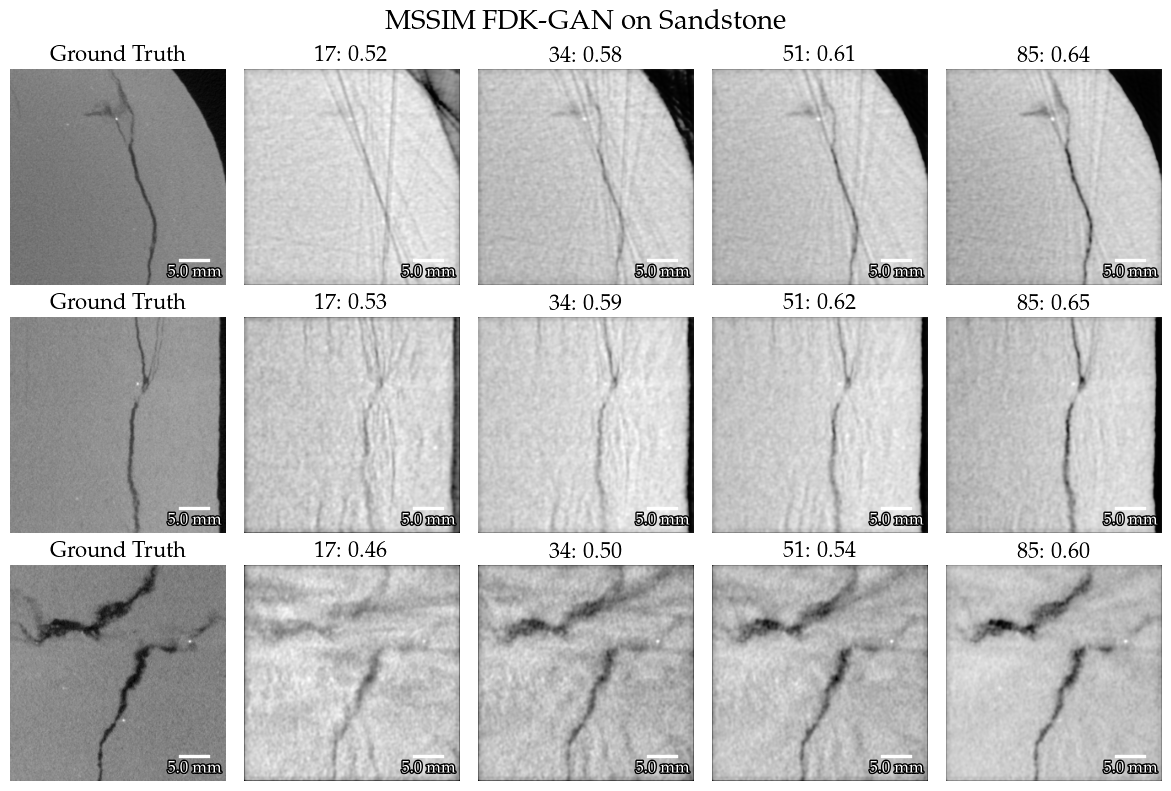

In [5]:
all_slices = []
all_labels = []

# slice_norm = lambda x, ref: (x - np.min(ref)) / (np.max(ref) - np.min(ref))
# slice_norm = lambda x, ref : (x-np.mean(ref[0:10, 0:10, -10:])) / (np.mean(ref[10:20, 10:20, 10:20]))
# slice_norm = lambda x, ref : (x-np.min(x)) / (np.max(x) - np.min(x))
# slice_norm = lambda x, ref : (x-np.min(x)) * (np.max(ref) - np.min(ref)) / (np.max(x) - np.min(x)) + np.min(ref)
slice_norm = lambda x, ref : x* (np.max(ref) - np.min(ref)) + np.min(ref)
volume_norm = lambda x, ref : (x-np.min(ref)) / (np.max(ref) - np.min(ref))

print(np.min(crossections["17_enhanced"]), np.max(crossections["17_enhanced"]))




#Current solution is to normalise SIRT and FDK with respect to the GT.
# This is not ideal, because GAN is already normalised. 
 
slice_indexer_x = lambda x, h: x[h]
slice_indexer_y = lambda x, h: x[:,h]
slice_indexer_z = lambda x, h: x[:,:,h]

slice_indexer = [slice_indexer_x, slice_indexer_y, slice_indexer_z]
hs = [128, 100, 160]
keys = ["17", "34", "51", "85"] #Sandstone not re-reconstructed at this point. Satisfied with number of projections.

for i, si in enumerate(slice_indexer):

    slgt = si(crossections["gt"], hs[i]) # crossections["gt"]) #si(crossections["gt"], hs[i])
    all_slices.append(slgt)
    all_labels.append(f"Ground Truth")

    for n in keys:
        slout = slice_norm(si(crossections[n+"_enhanced"], hs[i]), crossections["gt"]) #,  si(crossections[key+"_enhanced"], hs[i]))# crossections[key + "_enhanced"]) #slice_norm(si(crossections[key+"_enhanced"], hs[i]), crossections["gt"])

        all_slices.append(slout)

        k=  11
        mssout, _ = utils.calc_mssim(  slgt , slout, k=k    )

        all_labels.append( f"{n}: {mssout:.2f}")

        ssout, _ = evaluate( slgt, slout, normalise=True)

        print(f"SSIM {i} {n}: {ssout:.2f}")

scale_kwargs = {
    "size": 5 / (0.2 * 930) * 1350,
    "label": f"5.0 mm",
    "color": "white",
    "loc": 4,
    "frameon": False,
    "size_vertical": 3,
    "label_top": False,
    # "font_properties": {"size": 16}
}
plot_slice_grid(
    all_slices,
    all_labels,
    suptitle=f"MSSIM FDK-GAN on Sandstone",
    folder="Sandstone",
    savefile="BZ_test",
    savefig=True,
    bar = True,
    scalebar_kwargs=scale_kwargs,
    fs = (2,3),
    ns = (3,5)    
)

['Ground Truth', '17: 0.52', '34: 0.58', '51: 0.61', '85: 0.64', 'Ground Truth', '17: 0.53', '34: 0.59', '51: 0.62', '85: 0.65', 'Ground Truth', '17: 0.46', '34: 0.50', '51: 0.54', '85: 0.60']


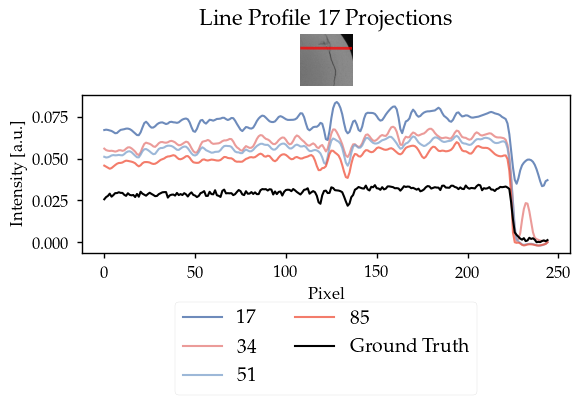

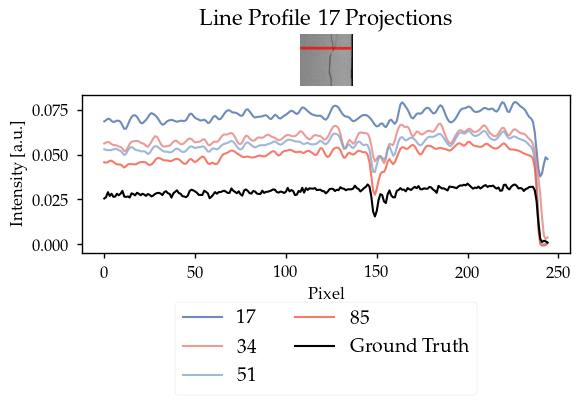

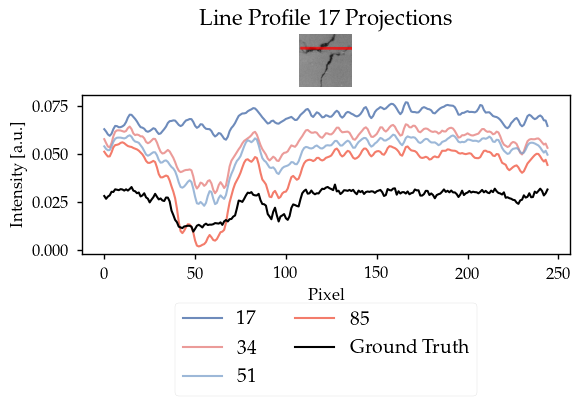

In [25]:
print(all_labels)
for x in range(0, len(all_labels)-4, 5):

    imgs = [all_slices[x+1], all_slices[x+2], all_slices[x+3], all_slices[x+4]]
    line_gt = all_slices[x]
    idxs= [128, 129, 10,255]
    plot_line_profile(imgs, keys, line_gt, idxs= [69, 70, 10, 255], folder="Sandstone", title="Line Profile 17 Projections", savefig=False, savefile=f"Sandstone_line_profile_17_projections_{x}")

In [6]:
name =     "hourglassV3_13_55"
id = "Rec_0_4_fdk_enhanced_800512512"

load_name = f"{name}_{id}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}.npy"
load_path = os.path.join(root, load_name)
hr = np.squeeze(np.load(load_path))

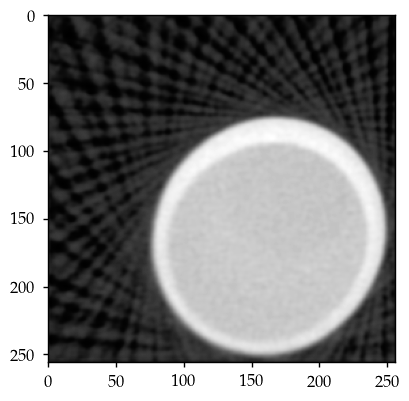

In [9]:
plt.imshow(hr[160,:,:], cmap="gray")
plt.show()